# Anomalies
The goals of today's exercise are to explain and calculate the following: 
- What is an anomaly?
- Example of the annual temperature anomaly of Leipzig
- Hands on: Calculate the monthly SST anomalies for the Nino 3.4 index
- Homework: Correlate the index with the SOI (Southern Oscillation Index) and other vegetational or meteorological variables in different regions 

## What is an anomaly?

**TODO**: Type your answer here
- something that deviates from what is standard, normal, or expected.
- X - X(average)
- deviation from the common rule

## Annual temperature anomaly of Leipzig

In [1]:
# import modules
import numpy as np
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load ESDC from SC cluster
ds = xr.open_zarr(fsspec.get_mapper('/work/users/gy963viny/public/EarthSystemDataCube/v2.1.1/esdc-8d-0.25deg-184x90x90-2.1.1.zarr/'), \
                  consolidated=True)

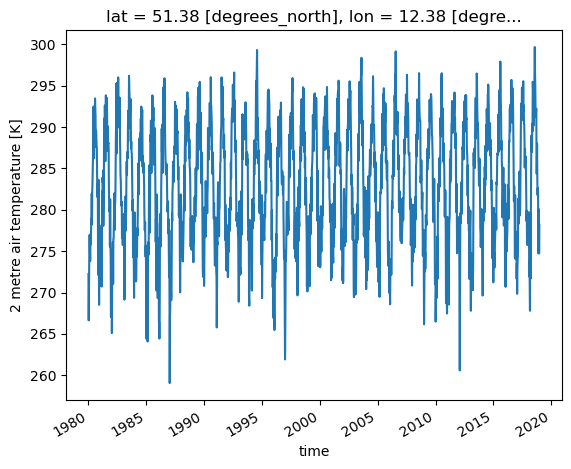

In [3]:
# Select the area of Leipzig
temp_leipzig = ds.air_temperature_2m.sel(lat=[51.3], lon=[12.3], method='nearest')
# The 'nearest' method still include the latitude and longitude and not only the variable. Therefore we extract lat=0 and lon=0
temp_leipzig = temp_leipzig.isel(lat=0, lon=0)
temp_leipzig.plot()

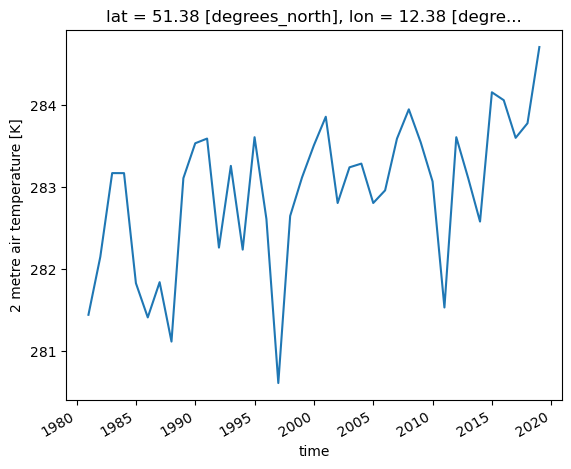

In [4]:
# Resample to annual data
annual_temp_leipzig = temp_leipzig.resample(time='Y').mean()
annual_temp_leipzig.plot()

<xarray.DataArray 'air_temperature_2m' ()>
array(282.9372, dtype=float32)
Coordinates:
    lat      float64 51.38
    lon      float64 12.38


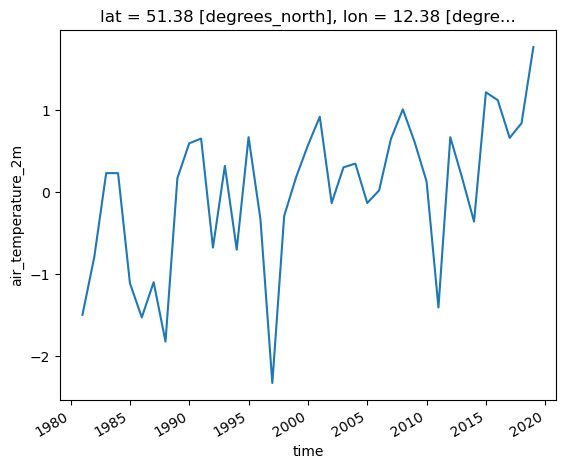

In [5]:
# Calculate the anomaly anomaly = x - x_bar
print(annual_temp_leipzig.mean())
anomaly_temp = annual_temp_leipzig - annual_temp_leipzig.mean()
anomaly_temp.plot()

The anomaly always depends on the reference period. In our example we calculated the the reference period from 1981-2019.
You find reference values for time periods between, e.g. 1961-1990, here https://www.dwd.de/DE/leistungen/klimadatendeutschland/vielj_mittelwerte.html (sorry, only German) and can choose the mean average temperature (1961-1990) from this table: https://www.dwd.de/DE/leistungen/klimadatendeutschland/mittelwerte/temp_6190_fest_html.html;jsessionid=9E9C49B729A580F1DBA49E38B806D402.live11051?view=nasPublication&nn=16102.
It is 9.1$^\circ$C. Now we can calculate the anomaly also in respect to this reference as well:

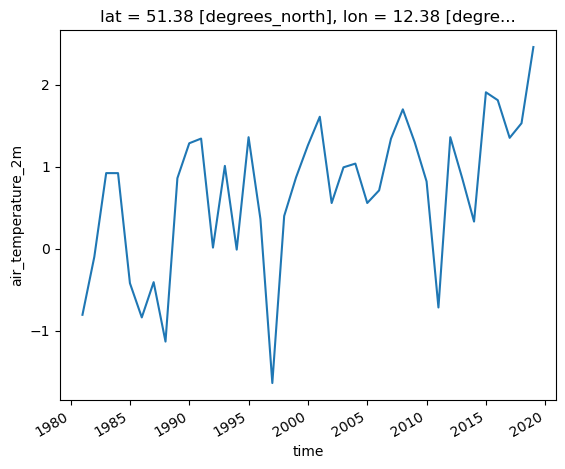

In [6]:
# anomaly with respect to reference period between 1961-1990
anomaly_temp = annual_temp_leipzig - (9.1+273.15)
anomaly_temp.plot()

## ENSO

### Which different indices are used to monitor the tropical Pacific?

**TODO**: Type your answer here
- Combined Variable El Niño index
- Southern Oscillation Index
- Equatorial Southern Oscillation Index
- Sea Surface Temperature Timeseries
- Oceanic Niño Index (ONI)
- and more...

### Calculate the Nino 3.4 index

Find more information on the indices and an example of the sea surface temperature (SST) anomalies here: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni.

**TODO**: Determine the Nino 3.4 index by the sea surface temperature anomalies for the time period that is covered by the ESDC. You are encouraged to think about your own solution and implement your ideas. These steps are only one example to solve this task. Think about the steps before without programming. Then start implementing your steps.

One solution could look like this:
1. Select the region of the Nino3.4 (5N-5S, 170W-120W) from the ESDC
2. Choose the variable `analysed_sst`
3. Resample the data to monthly data
4. Calculate the anomalies in this region (still 3D)
5. Calculate the mean of this anomaly area
6. Smooth your data with a running window of 5 months
7. Identify strong El Nino and La Nina periods in the plot

Programming hints are below the next cell. 

In [7]:
sst = ds.analysed_sst.sel(lat=slice(5, -5), lon=slice(-170, -120))
sst = sst.resample(time="M").mean('time')
sst_average = sst.groupby("time.month").mean("time")
sst_anomaly = sst.groupby("time.month") - sst_average
sst_mean_anomaly = sst_anomaly.mean('lat').mean('lon')
sst_smooth = pd.Series(sst_mean_anomaly).rolling(window=5).mean().iloc[5-1:].values
sst_smooth = sst_smooth[~np.isnan(sst_smooth)]

In [8]:
sst_max = sst_smooth.max()
sst_2max = np.partition(sst_smooth.flatten(), -2)[-2]
sst_min = sst_smooth.min()
sst_2min = np.partition(sst_smooth.flatten(), 1)[1]

There are more information on the Xarray functions in the documentation (https://docs.xarray.dev/en/stable/user-guide/index.html). Try around with the functions you have already seen in other Jupyternotebooks from this course, especially the functions `.sel()`, `slice()`, `.resample(time='M')`, `.resample(time='Y')`, `groupby('time.month')`, `mean()`.

1. Think about the function `.sel()` and apply the `slice()` function to the extent of the Nino3.4 region (5N-5S, 170W-120W)
2. ds.analised_sst
3. You can resample the DataArray with the function `.resample(time='Y')` and substitute die annual resampling `Y` to `M` (for month) and calculate the mean by applying `.mean('time')`
4. Calculate the average for each month of the year by applying `.groupby('time.month')` and `.mean('time')`. Then determine the anomalies by computing the difference between the resampled monthly data and the averaged monthly data. Here the dimensions are not equal, therefore use the function `groupby('time.month')` to the resampled monthly data again. 
5. Now you can apply the `mean()` function on the latitudes `lat` and longitudes `lon`.
6. There are different ways to calculate the running window. You can do it from scratch or e.g. google any solution. One solution could be this: 
`import pandas as pd`
`weighted = pd.Series(array).rolling(window=n).mean().iloc[n-1:].values`, with the anomaly array 'array' and 'n' as the size of the window.


### Plotting the Nino3.4 indice against other variables

**TODO**: Now you can plot the anomaly against the SOI index. Also you can plot it against other vegetation and meteorologic variables in other areas of the earth (e.g. Net primary productivity in Southamerica or precipitation in Australia). Feel highly encouraged to try different variables and regions and be prepared to share your results in the next exercise.

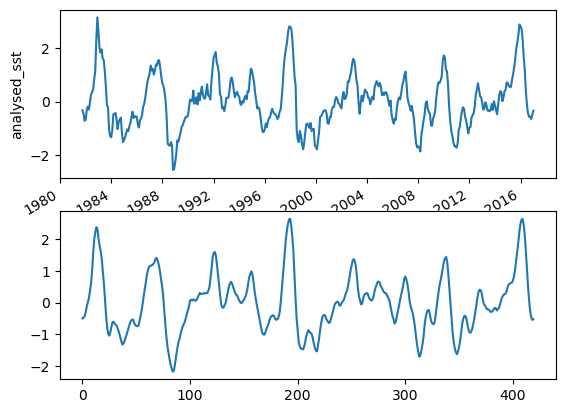

In [9]:
plt.subplot(2, 1, 1)
sst_mean_anomaly.plot()
plt.subplot(2, 1, 2)
plt.plot(sst_smooth)

![SOI](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/oni.monthly.smoo_stro.png?itok=KX4FZyFw)

In [10]:
sst_anomaly.plot(x='lon', y='lat', col='time', col_wrap=12, robust=True)

Error in callback <function _draw_all_if_interactive at 0x14c8fe267f70> (for post_execute):


In [11]:
# GPP in South America
south_gpp = ds.gross_primary_productivity.sel(lat=slice(5, -60), lon=slice(-85, -30))
south_gpp_res = south_gpp.resample(time="M").mean('time')
south_anomaly = south_gpp_res.groupby("time.month") - south_gpp_res.groupby("time.month").mean("time")
south_mean_anomaly = south_anomaly.mean('lat').mean('lon')
south_smooth = pd.Series(south_mean_anomaly).rolling(window=5).mean().iloc[5-1:].values

In [12]:
# Precipitation in Australia
aus_prec = ds.precipitation.sel(lat=slice(-10, -45), lon=slice(110, 155))
aus_prec_res = aus_prec.resample(time="M").mean('time')
aus_anomaly = aus_prec_res.groupby("time.month") - aus_prec_res.groupby("time.month").mean("time")
aus_mean_anomaly = aus_anomaly.mean('lat').mean('lon')
aus_smooth = pd.Series(aus_mean_anomaly).rolling(window=5).mean().iloc[5-1:].values

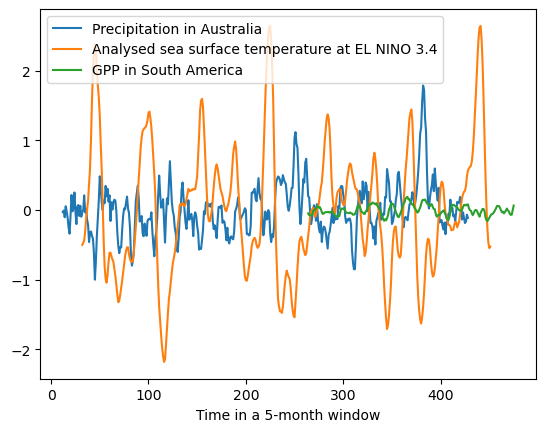

In [13]:
# to achive same list lenghts doing smoothing for sst again
sst_smooth = pd.Series(sst_mean_anomaly).rolling(window=5).mean().iloc[5-1:].values

plt.plot(aus_smooth, label='Precipitation in Australia')
plt.plot(sst_smooth, label='Analysed sea surface temperature at EL NINO 3.4')
plt.plot(south_smooth, label='GPP in South America')
plt.xlabel("Time in a 5-month window")
plt.legend()